Transfer Learning - VGG19 Cats and Dogs
    
    Feature Extraction    
    Fine-Tuning

In [42]:
import numpy as np
import pandas as pd
import os
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [35]:
def format_data(path, path2, label, label2):
    files = os.listdir(path) 
    paths = [r"{}\{}".format(path,i) for i in files]
    
    files = os.listdir(path2) 
    paths2 = [r"{}\{}".format(path2,i) for i in files]
    
    df = pd.DataFrame(paths, columns=['Path'])
    df['Label'] = label
    
    df2 = pd.DataFrame(paths2, columns=['Path'])
    df2['Label'] = label2
    
    return df.append(df2).reset_index(drop=True)

In [65]:
train_cat_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\train\cats"
train_dog_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\train\dogs"

train_df = format_data(path=train_cat_images_directory,
                       path2=train_dog_images_directory,
                       label="cat",
                       label2="dog")

val_cat_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\validation\cats"
val_dog_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\validation\dogs"

val_df = format_data(path=val_cat_images_directory,
                       path2=val_dog_images_directory,
                       label="cat",
                       label2="dog")

In [66]:
train_df.head()

,Path,Label
0,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
1,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
2,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
3,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
4,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat


cat


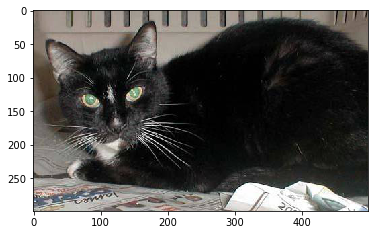

In [83]:
plt.imshow(imread(train_df['Path'][123]))
print(train_df['Label'][123])

### VGG19 Architecture
https://www.tensorflow.org/alpha/tutorials/images/transfer_learning

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [68]:
IMG_SHAPE = (150, 150, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [69]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 8192)              32768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 22,155,841
Trainable params: 2,114,561
Non-trainable params: 20,041,280
__________________________________

In [76]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [81]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                      x_col="Path", 
                                                      y_col="Label", 
                                                      target_size=(150,150),
                                                      class_mode="binary",
                                                      batch_size=32)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_df,
                                                                x_col="Path", 
                                                                y_col="Label", 
                                                                target_size=(150,150),
                                                                class_mode="binary",
                                                                batch_size=32)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [82]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50  
)

Epoch 1/30
100/100 [==============================] - 39s 390ms/step - loss: 0.5218 - accuracy: 0.7660 - val_loss: 0.4709 - val_accuracy: 0.7392
Epoch 2/30
100/100 [==============================] - 26s 262ms/step - loss: 0.4378 - accuracy: 0.8078 - val_loss: 0.3521 - val_accuracy: 0.8509
Epoch 3/30
100/100 [==============================] - 26s 256ms/step - loss: 0.4053 - accuracy: 0.8160 - val_loss: 0.2846 - val_accuracy: 0.8883
Epoch 4/30
100/100 [==============================] - 26s 258ms/step - loss: 0.3741 - accuracy: 0.8351 - val_loss: 0.2788 - val_accuracy: 0.8750
Epoch 5/30
100/100 [==============================] - 25s 255ms/step - loss: 0.3381 - accuracy: 0.8545 - val_loss: 0.2995 - val_accuracy: 0.8832
Epoch 6/30
100/100 [==============================] - 28s 277ms/step - loss: 0.3426 - accuracy: 0.8485 - val_loss: 0.2964 - val_accuracy: 0.8813
Epoch 7/30
100/100 [==============================] - 26s 257ms/step - loss: 0.3283 - accuracy: 0.8552 - val_loss: 0.3188 - val_ac

In [85]:
model.save_weights("vgg19_cats_and_dogs_fe.h5py")

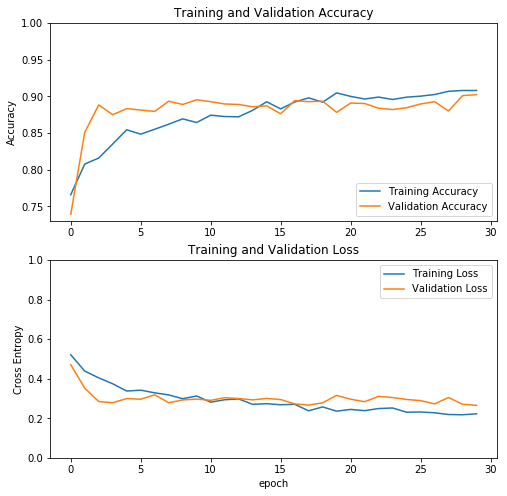

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [109]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  22


In [110]:
model.load_weights("vgg19_cats_and_dogs_fe.h5py")
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 8192)              32768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 22,155,841
Trainable params: 13,913,601
Non-trainable params: 8,242,240
__________________________________

In [112]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

In [115]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath="VGG19_CAT_AND_DOGS_BEST.h5py",monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks = [checkpoint]

In [116]:
history_fine = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/40
 99/100 [============================>.] - ETA: 0s - loss: 0.2071 - accuracy: 0.9152
Epoch 00001: val_loss improved from inf to 0.29864, saving model to VGG19_CAT_AND_DOGS_BEST.h5py
100/100 [==============================] - 32s 322ms/step - loss: 0.2084 - accuracy: 0.9154 - val_loss: 0.2986 - val_accuracy: 0.8858
Epoch 2/40
 99/100 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9312
Epoch 00002: val_loss improved from 0.29864 to 0.25990, saving model to VGG19_CAT_AND_DOGS_BEST.h5py
100/100 [==============================] - 27s 268ms/step - loss: 0.1681 - accuracy: 0.9312 - val_loss: 0.2599 - val_accuracy: 0.9175
Epoch 3/40
 99/100 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9295
Epoch 00003: val_loss improved from 0.25990 to 0.23370, saving model to VGG19_CAT_AND_DOGS_BEST.h5py
100/100 [==============================] - 27s 270ms/step - loss: 0.1692 - accuracy: 0.9283 - val_loss: 0.2337 - val_accuracy: 0.9175
Epoch 4/40


 99/100 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9821
Epoch 00029: val_loss did not improve from 0.16884
100/100 [==============================] - 27s 270ms/step - loss: 0.0462 - accuracy: 0.9823 - val_loss: 0.2000 - val_accuracy: 0.9416
Epoch 30/40
 99/100 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9860
Epoch 00030: val_loss did not improve from 0.16884
100/100 [==============================] - 27s 269ms/step - loss: 0.0399 - accuracy: 0.9859 - val_loss: 0.2116 - val_accuracy: 0.9397
Epoch 31/40
 99/100 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9828
Epoch 00031: val_loss did not improve from 0.16884
100/100 [==============================] - 27s 269ms/step - loss: 0.0450 - accuracy: 0.9826 - val_loss: 0.3023 - val_accuracy: 0.9169
Epoch 32/40
 99/100 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9860
Epoch 00032: val_loss did not improve from 0.16884
100/100 [=========

In [117]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

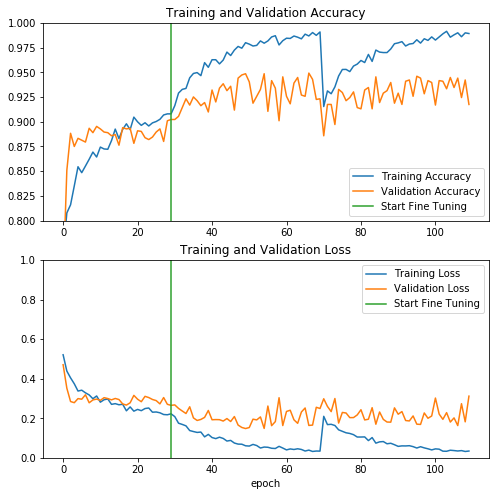

In [118]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([30-1,30-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([30-1,30-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [120]:
model.save_weights("vgg19_cats_and_dogs_ft.h5py")